In [1]:
from sklearn.linear_model import Ridge
from datetime import timedelta, date
from scipy.stats import pearsonr
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from workalendar.usa import new_york

 Добавим данные за 2015.

In [3]:
path_list = ['agr_2015.csv', 'agr_2016.csv']

In [4]:
all_data = pd.DataFrame()
for path in path_list:
    r_data = pd.read_csv(path, sep = ',')
    r_data.set_index('dt', inplace=True)
    r_data.index = pd.to_datetime(r_data.index)
    all_data = pd.concat([all_data, r_data], axis = 0)
all_data.head()      

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Отбор 102 регионов

In [6]:
data_may = all_data.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00', :]
(data_may.mean()>5).sum()

102

In [ ]:
i_columns = data_may.loc[:, data_may.mean()>5].columns
f_data = all_data.loc[:, all_data.columns.str.contains('|'.join(i_columns))]

In [9]:
f_data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,...,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,...,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0
2015-01-01 02:00:00,99.0,179.0,39.0,127.0,372.0,409.0,391.0,443.0,475.0,180.0,...,48.0,0.0,2.0,1.0,2.0,0.0,0.0,5.0,0.0,1.0
2015-01-01 03:00:00,80.0,116.0,19.0,79.0,325.0,461.0,315.0,415.0,335.0,159.0,...,34.0,0.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0
2015-01-01 04:00:00,25.0,54.0,15.0,69.0,172.0,319.0,274.0,364.0,371.0,132.0,...,38.0,0.0,5.0,2.0,3.0,4.0,0.0,3.0,0.0,16.0


## Добавление признаков

In [10]:
data = f_data.copy()

In [12]:
# месяц, день месяца, день недели, чаc
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['day of week'] = data.index.dayofweek
data['hour'] = data.index.hour

# годовые, месячные и суточные признаки Фурье
K = 15
year_period = 8766 #365.2424*24 - средняя продолжительность года в часах
week_period = 168
day_period = 24
for i in range(1, K+1):
    data['y_с_' + str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
    data['y_s_' + str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/year_period)
for i in range(1, K+1):    
    data['w_с_' + str(i)] = 1.0/1.4142135623730951*np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
    data['w_s_' + str(i)] = 1.0/1.4142135623730951*np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/week_period)
for i in range(1, K+1):    
    data['d_с_' + str(i)] = 1.0/1.4142135623730951*np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)
    data['d_s_' + str(i)] = -1.0/1.4142135623730951*np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/day_period)   

C:\ProgramData\Anaconda2\lib\site-packages\dateutil\parser\_parser.py:113: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':


**Cырые данные**

* Средняя стоимость поездок
* Среднее число пассажиров
* Средняя протяженность поездок

In [13]:
def p_data(file_name):
    all_data = pd.read_csv('./TAXI DATA/CSVs/'+file_name, sep = ',')
    all_data.set_index('dt', inplace=True)
    all_data.index = pd.to_datetime(all_data.index)
    f_data = all_data.loc[:, all_data.columns.str.contains('|'.join(i_columns))]
    f_data.columns = new_columns_names 
    return f_data

In [14]:
mean_passenger_count = p_data('agr_2016_mean_passenger_count.csv')
mean_total_amount = p_data('agr_2016_mean_total_amount.csv')
mean_trip_distance = p_data('agr_2016_mean_trip_distance.csv')

In [15]:
mean_passenger_count.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2.037500,2.090278,2.020000,1.883117,1.858934,1.898010,1.847458,1.721232,1.725768,1.760300,...,1.666667,0.0,1.0,1.840909,2.6,1.292683,3.25,1.828571,1.714286,1.681818
2016-01-01 01:00:00,1.758242,1.853081,1.734694,1.679104,2.037129,2.016667,1.816216,1.953642,1.872054,1.852679,...,1.551724,0.0,1.0,3.500000,1.0,2.000000,0.00,1.659574,2.000000,2.206897


In [16]:
mean_total_amount.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,17.590625,18.522569,18.840600,20.781299,17.104138,16.127711,16.219228,14.962512,15.889243,17.052285,...,13.312500,0.0,9.050,32.650682,27.372,46.09122,43.76,42.606286,41.195714,47.845455
2016-01-01 01:00:00,21.060879,21.871469,19.050408,19.802388,19.037005,16.616310,17.025216,16.373753,16.485135,17.244554,...,13.334828,0.0,11.652,38.430000,6.300,44.86500,0.00,44.073830,63.360000,50.366552


In [17]:
mean_trip_distance.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,3.972625,3.933403,4.159600,4.682338,3.721411,3.219776,3.031394,2.662447,2.828593,2.836554,...,2.762500,0.0,1.375,8.420909,7.404,13.225122,11.905,12.789429,16.18,14.546212
2016-01-01 01:00:00,4.930330,4.865687,3.916122,4.359030,4.189703,3.341071,3.255946,2.941038,2.926128,2.954018,...,2.828276,0.0,1.934,11.370000,0.955,14.297500,0.000,13.586596,19.10,15.416207


**Праздники**

In [18]:
callendar = new_york.NewYork()

In [20]:
callendar_data = pd.DataFrame(f_data.index)
callendar_data['working_day'] = [int(callendar.is_working_day(x)) for x in callendar_data.dt]
callendar_data['holiday'] = [int(callendar.is_holiday(x)) for x in callendar_data.dt]
callendar_data.set_index('dt', inplace=True)

In [21]:
callendar_data.head()

,working_day,holiday
dt,,
2015-01-01 00:00:00,0,1
2015-01-01 01:00:00,0,1
2015-01-01 02:00:00,0,1
2015-01-01 03:00:00,0,1
2015-01-01 04:00:00,0,1


**Номера кластеров (K-means и силуэтный анализ)**

In [23]:
def o_c_d(method, data, max_n_clusters, print_answer = False):
    score_list = []
    for n_clusters in range(2, max_n_clusters+1):
        res = method(n_clusters = n_clusters).fit_predict(data)
        score = silhouette_score(data, res)
        score_list.append(score)
    if print_answer == True:            
        print 'Максимальный коэффициент силуэта равен {}. Достигнут при числе кластеров равном {}'\
        .format(max(score_list), score_list.index(max(score_list))+2)
        return 
    return score_list   

In [24]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(f_data), 
                       columns = f_data.columns, index =f_data.index)

In [25]:
max_n_clusters = 10

In [26]:
o_c_d(KMeans, scaled_data, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.332514800529. Достигнут при числе кластеров равном 3


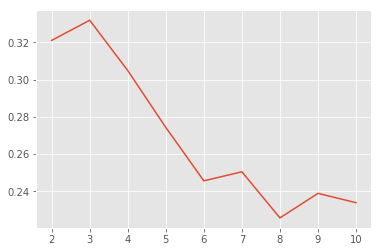

In [27]:
plt.plot(np.arange(2, max_n_clusters+1), o_c_d(KMeans, scaled_data, max_n_clusters))

In [41]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)
import pandas as pd 

Automatically created module for IPython interactive environment


('For n_clusters =', 2, 'The average silhouette_score is :', 0.24986868519659264)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.25142199269366944)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.1964415105314299)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.2005428002173488)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.19133557373180957)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.19181659560068287)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.17021122864786492)


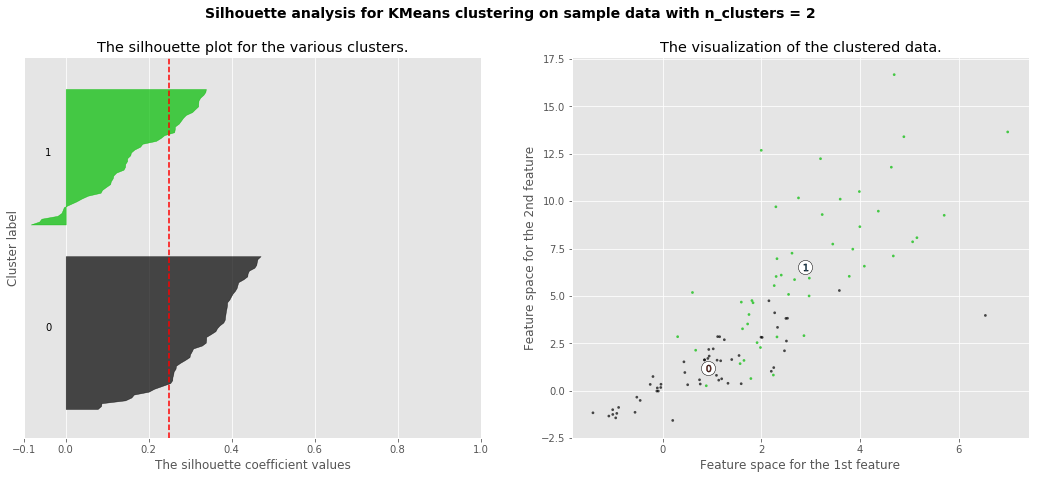

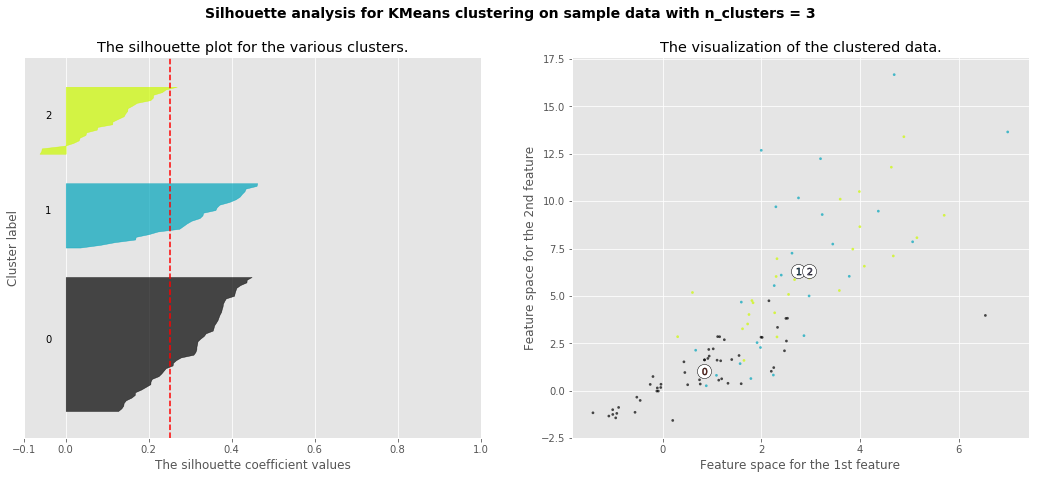

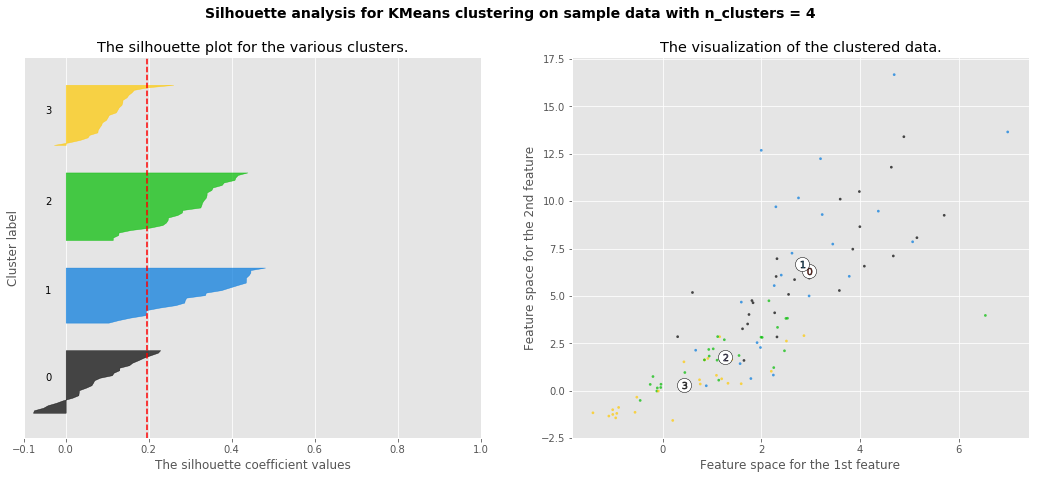

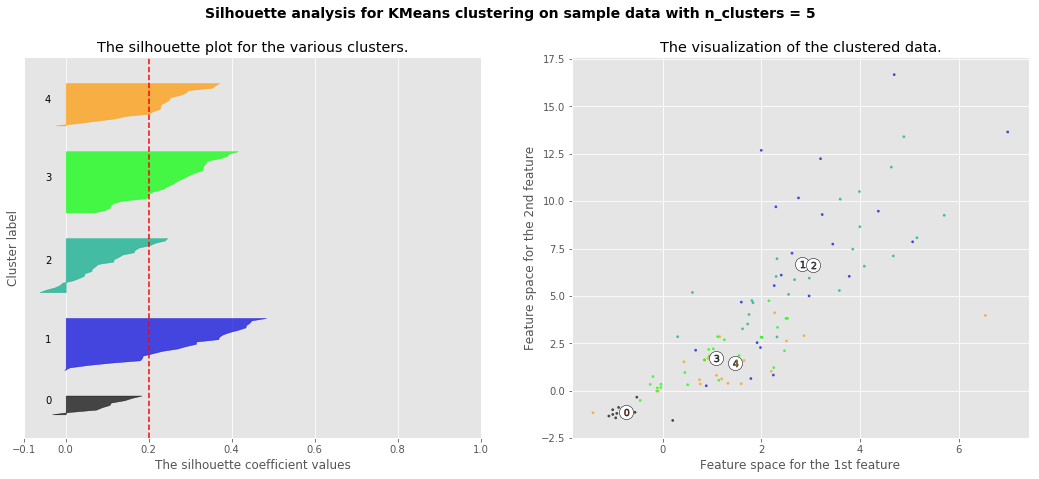

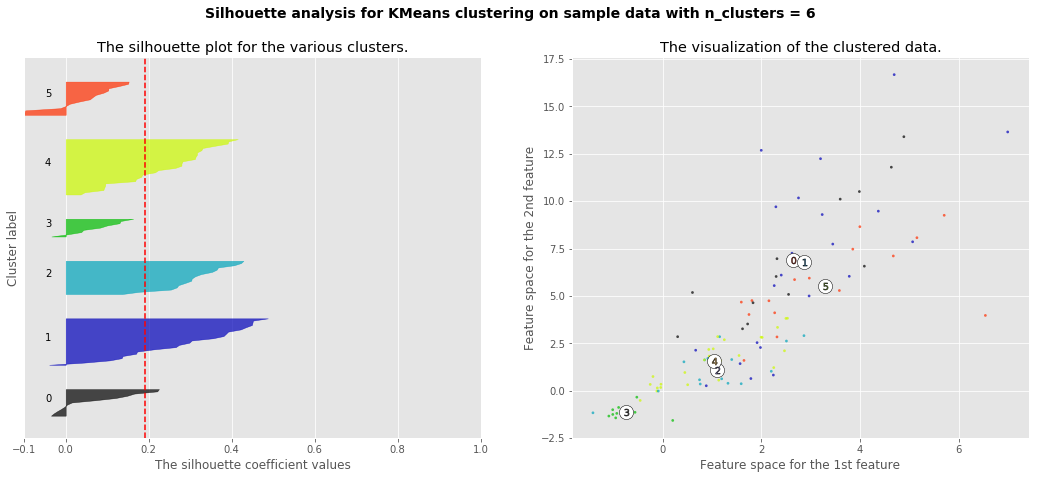

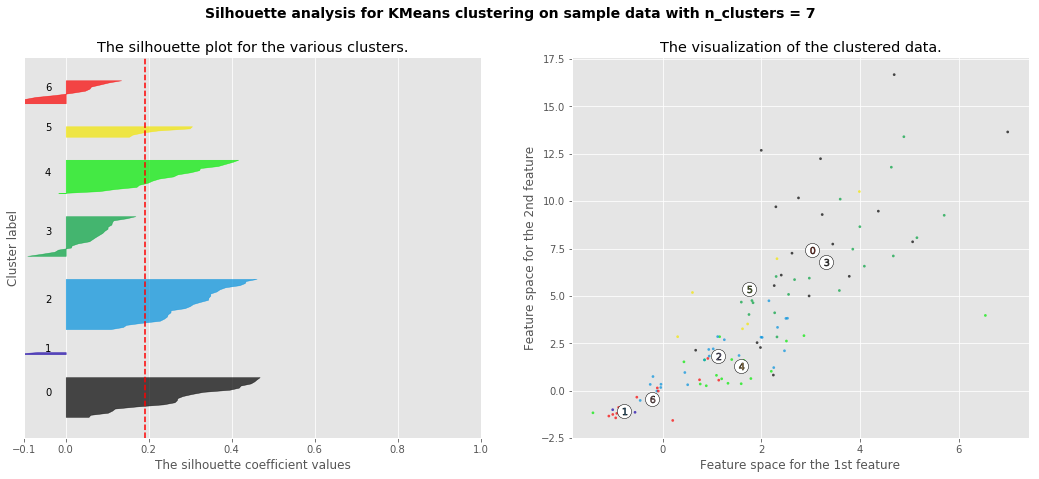

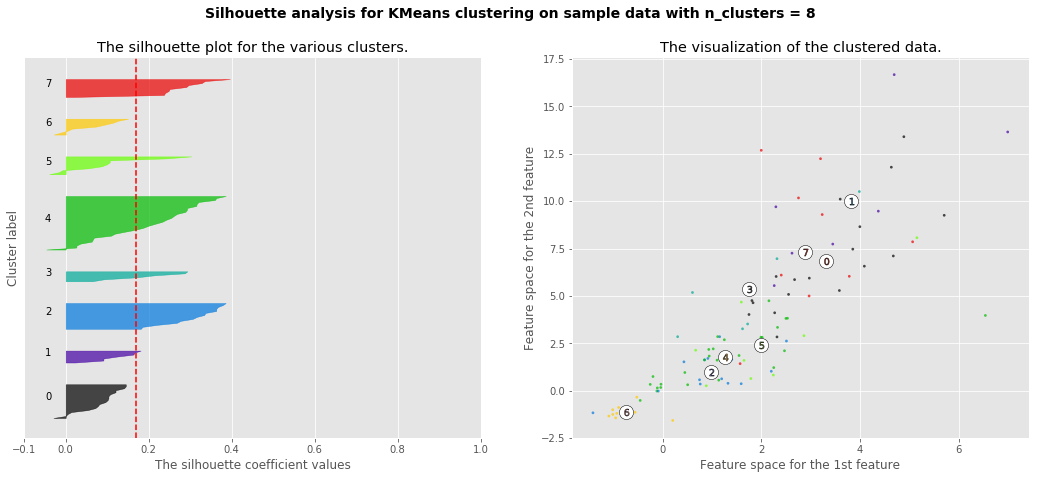

In [52]:
XX=scaled_data.copy()
X=XX.T.as_matrix()
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    ax2.scatter(X[:, 0], X[:, 1], marker='.',s=30,  lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Разбиваем на 8 кластеров

In [29]:
cluster_model = KMeans(n_clusters = 8)
res = cluster_model.fit_predict(f_data)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([1356, 1583, 2566, 3015,  520,  922, 1135, 2031], dtype=int64))

In [30]:
cluster_numbers_data = pd.DataFrame(f_data.index)
cluster_numbers_data.set_index('dt', inplace=True)
cluster_numbers_data['label'] = res

# Модель

Были проведены многочисленные эксперименты по отбору признаков с помощью кластеризации рядов, RandomForestRegression, PCA и других, что приводило только к увеличению ошибки.
В результате оставлен Ridge Regression.

**Конечный  набор признаков**

In [34]:
%%time

import warnings
warnings.filterwarnings('ignore')


data = pd.concat([data, cluster_numbers_data, callendar_data], axis = 1)

linear_models_dict = {}

X_val_dict = {}
y_val_dict = {}
y_val_pred_dict = {}

X_test_dict = {}
y_test_dict = {}
y_test_pred_dict = {}

for id_name in f_data.columns:
    print id_name,
    drop_list = list(f_data.columns)
    drop_list.remove(str(id_name))
    named_data = data.copy().drop(drop_list, axis = 1) 
    
   
    named_data['shift_1'] = named_data[str(id_name)].shift(1)
    named_data['shift_2'] = named_data[str(id_name)].shift(2)
    named_data['shift_3'] = named_data[str(id_name)].shift(3)
    named_data['shift_4'] = named_data[str(id_name)].shift(4)
    named_data['shift_5'] = named_data[str(id_name)].shift(5)
    named_data['shift_6'] = named_data[str(id_name)].shift(6)          
    named_data = named_data.iloc[6:]
    
   
    predict_may_start = '2016-04-30 23:00'
    predict_may_stop = '2016-05-31 23:00'
    precit_june_stop = '2016-06-30 23:00' 
    
    X_train = named_data.loc[:predict_may_start].drop(str(id_name), axis = 1)
    y_train = named_data.loc[:predict_may_start][str(id_name)]
    
    X_val = named_data.loc[predict_may_start:predict_may_stop].drop(str(id_name), axis = 1)
    y_val = named_data.loc[predict_may_start:predict_may_stop][str(id_name)]
    
    X_test = named_data.loc[predict_may_stop:].drop(str(id_name), axis = 1)
    y_test = named_data.loc[predict_may_stop:][str(id_name)]
    
   
    model = linear_model.Ridge()
    param_grid = [{'alpha' : np.logspace(1, 3, 10)}]
    clf = GridSearchCV(model, param_grid, cv = 5)
    best_model = clf.fit(X_train, y_train)
    
    
    linear_models_dict[id_name] = best_model
    X_val_dict[id_name] = X_val
    y_val_dict[id_name] = y_val
    y_val_pred_dict[id_name] = best_model.predict(X_val)
    X_test_dict[id_name] = X_test
    y_test_dict[id_name] = y_test
    y_test_pred_dict[id_name] = best_model.predict(X_test)


1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168Wall time: 3min 13s



**Анализ Q_may**

In [35]:
may_time_range = pd.date_range('2016-04-30 23:00', '2016-05-31 17:00', freq = 'H')

In [36]:
%%time
Q_may_f = 0
for key in f_data.columns:
    print key,
    for date in may_time_range:
        for step in range(1, 7):
           
            forecast = pd.DataFrame(y_val_pred_dict.get(str(key)), index = y_val_dict.get(str(key)).index, columns = ['val'])
            real_values = y_val_dict.get(str(key))
            Q_may_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_may = float(Q_may_f/(102*739*6))
print 
print 'Q_may: ', Q_may

1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168
Q_may:  16.9177074122
Wall time: 6min 37s


Стало лучше

**Анализ Q_june**

In [37]:
june_time_range = pd.date_range('2016-05-31 23:00', '2016-06-30 17:00', freq = 'H')

In [38]:
%%time
Q_june_f = 0
title_list = []
prediction_list = []
for key in f_data.columns:
    print key,
    for date in june_time_range:
        for step in range(1, 7):
            
            forecast = pd.DataFrame(y_test_pred_dict.get(str(key)), index = y_test_dict.get(str(key)).index, columns = ['val'])
            real_values = y_test_dict.get(str(key))
     
                
            prediction_list.append(float(forecast.loc[date + timedelta(hours = step)]))
            title_list.append(str(key) + '_' + str(date)[:10]+ '_' + str(date.hour) + '_' + str(step))  
            
            Q_june_f+= np.abs(forecast.loc[date + timedelta(hours = step)] - real_values.loc[date + timedelta(hours = step)])
Q_june = float(Q_june_f/(102*739*6))

1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168Wall time: 8min 3s



In [39]:
kaggle_week6 = pd.DataFrame(prediction_list, index = title_list, columns = ['y'])
kaggle_week6.index.name = 'id'
print kaggle_week6.shape
kaggle_week6.head()

(437580, 1)


,y
id,
1075_2016-05-31_23_1,22.363776
1075_2016-05-31_23_2,13.706509
1075_2016-05-31_23_3,2.660602
1075_2016-05-31_23_4,-0.469021
1075_2016-05-31_23_5,3.999719


## Kaggle результат

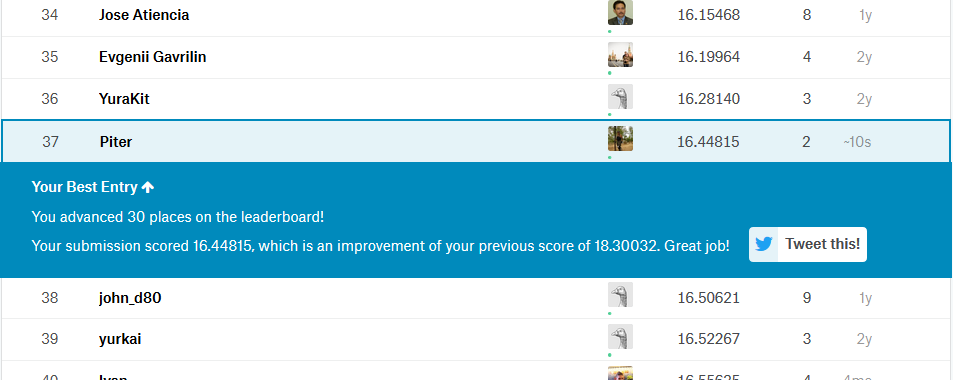

In [3]:
from IPython.display import Image
Image("G6png.png") 